In [ ]:
!pip install pandas
!pip install numpy
!pip install nltk
!pip install stanfordnlp
!pip install stanza

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 12.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import stanfordnlp
import stanza
from nltk.sentiment import SentimentIntensityAnalyzer


In [ ]:
stanza.download('en')
stanfordnlp.download('en')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

INFO:stanza:Downloading default packages for language: en (English) ...
INFO:stanza:File exists: /root/stanza_resources/en/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources.


Using the default treebank "en_ewt" for language "en".
Would you like to download the models for: en_ewt now? (Y/n)
y

Default download directory: /root/stanfordnlp_resources
Hit enter to continue or type an alternate directory.


Download location: /root/stanfordnlp_resources/en_ewt_models.zip


100%|██████████| 235M/235M [00:40<00:00, 5.83MB/s]



Download complete.  Models saved to: /root/stanfordnlp_resources/en_ewt_models.zip
Extracting models file for: en_ewt
Cleaning up...Done.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
data = pd.read_excel('Filtered_Surveys_Preprocessed_eng_v1.xlsx')

In [ ]:
def aspect_sentiment_analysis(txt, stop_words, nlp):
    txt = txt.lower() # LowerCasing the given Text
    sentList = nltk.sent_tokenize(txt) # Splitting the text into sentences

    fcluster = []
    totalfeatureList = []
    finalcluster = []
    dic = {}

    for line in sentList:
        newtaggedList = []
        txt_list = nltk.word_tokenize(line) # Tokenize each line
        taggedList = nltk.pos_tag(txt_list) # Pos_tagging each token

        newwordList = []
        flag = 0
        for i in range(0, len(taggedList) - 1):
            if(taggedList[i][1] == "NN" and taggedList[i + 1][1] == "NN"):
                newwordList.append(taggedList[i][0] + taggedList[i + 1][0])
                flag = 1
            else:
                if(flag == 1):
                    flag = 0
                    continue
                newwordList.append(taggedList[i][0])
                if(i == len(taggedList) - 2):
                    newwordList.append(taggedList[i + 1][0])

        finaltxt = ' '.join(word for word in newwordList)
        new_txt_list = nltk.word_tokenize(finaltxt)
        wordsList = [w for w in new_txt_list if not w in stop_words]
        taggedList = nltk.pos_tag(wordsList)

        doc = nlp(finaltxt)


        dep_node = []
        for sentence in doc.sentences:
            for dep_edge in sentence.dependencies:
                dep_node.append([dep_edge[2].text, dep_edge[0].id, dep_edge[1]])


        for i in range(0, len(dep_node)):
          idx = int(dep_node[i][1]) - 1
          if idx < len(newwordList) and idx >= 0:
              dep_node[i][1] = newwordList[idx]


        featureList = []
        for i in taggedList:
            if(i[1] in ['JJ', 'NN', 'JJR', 'NNS', 'RB']):
                featureList.append(list(i))
                totalfeatureList.append(list(i))

        for i in featureList:
            filist = []
            for j in dep_node:
                if((j[0] == i[0] or j[1] == i[0]) and (j[2] in ["nsubj", "acl:relcl", "obj", "dobj", "agent", "advmod", "amod", "neg", "prep_of", "acomp", "xcomp", "compound"])):
                    if(j[0] == i[0]):
                        filist.append(j[1])
                    else:
                        filist.append(j[0])
            fcluster.append([i[0], filist])

    for i in totalfeatureList:
        dic[i[0]] = i[1]

    for i in fcluster:
        if(dic[i[0]] == "NN"):
            finalcluster.append(i)

    return finalcluster

def process_dataset_column(data, column_name):
    nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma,depparse')
    stop_words = set(stopwords.words('english'))
    data['Analysis_Result'] = data[column_name].apply(lambda x: aspect_sentiment_analysis(str(x), stop_words, nlp))
    return data

# Sample dataset
sample_data = pd.DataFrame({
    'Comment_Preprocessed': [
        "The Sound Quality is great but the battery life is very bad.",
        "The display is beautiful but it overheats often.",
        "Performance is exceptional!"
    ]
})

# Process the 'Comment_Preprocessed' column
processed_data = process_dataset_column(sample_data, 'Comment_Preprocessed')
print(processed_data)


INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Done loading processors!


                                Comment_Preprocessed  \
0  The Sound Quality is great but the battery lif...   
1   The display is beautiful but it overheats often.   
2                        Performance is exceptional!   

                                     Analysis_Result  
0    [[soundquality, [great]], [batterylife, [bad]]]  
1                           [[display, [beautiful]]]  
2  [[performance, [exceptional]], [exceptional, [...  


In [ ]:
processed_data = process_dataset_column(data, 'Comments_preprocessed')
print(processed_data)

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Done loading processors!


       Unnamed: 0  Brand                               Comments_translated  \
0               0     10  direct communication .excellent product service.   
1               1     10                            fast effective service   
2               2     10                       immediately service problem   
3               3     10              effective application court employer   
4               4     10           immediately effective treatment problem   
...           ...    ...                                               ...   
14951       14951     10                                        service ..   
14952       14952      9                  organization immediately service   
14953       14953     10                                           service   
14954       14954      8                                           service   
14955       14955     10                                   eugain employe!   

                                   Comments_preprocessed  \
0  

In [ ]:
processed_data['Analysis_Result'].values[2]

[['serviceproblem', ['immediately']]]

In [ ]:
processed_data['Comments_preprocessed'].values[2]

'immediately service problem'

In [ ]:
ex1 = 'Vodafone''s reception is so bad,but the service is great'

In [ ]:
stop_words = set(stopwords.words('english'))
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma,depparse')
aspect_sentiment_analysis(ex1,stop_words, nlp)

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Done loading processors!


[['reception', ['vodafones', 'bad']], ['service', ['great']]]

In [ ]:
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


INFO:stanza:Downloading default packages for language: en (English) ...
INFO:stanza:File exists: /root/stanza_resources/en/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources.


In [ ]:
def determine_aspect_sentiment(txt, stop_words, nlp):
    # Extract aspects and their associated words using your defined function
    aspect_clusters = aspect_sentiment_analysis(txt, stop_words, nlp)

    aspect_sentiments = {}

    # For each aspect and its associated words, determine sentiment using VADER
    for aspect, associated_words in aspect_clusters:
        # Combining the aspect with its associated words to form a mini-text
        mini_text = " ".join([str(aspect)] + [str(word) for word in associated_words])

        # Get sentiment compound score
        sentiment_score = sia.polarity_scores(mini_text)['compound']

        # Convert the sentiment score to 'positive', 'neutral', or 'negative'
        if sentiment_score >= 0.05:
            sentiment = "positive"
        elif sentiment_score <= -0.05:
            sentiment = "negative"
        else:
            sentiment = "neutral"

        aspect_sentiments[aspect] = sentiment

    return aspect_sentiments


In [ ]:
sample_sentence = "The Sound Quality is great but the battery life is very bad."
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma,depparse')
aspect_sentiments_result = determine_aspect_sentiment(sample_sentence, set(nltk.corpus.stopwords.words('english')), nlp)
print(aspect_sentiments_result)


INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Done loading processors!


{'soundquality': 'positive', 'batterylife': 'negative'}


In [ ]:
# Initialize the NLP pipeline using stanza
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma,depparse')

# Determine sentiment for the aspects in the 'Comments_translated' column
processed_data['Aspect_Sentiments'] = processed_data['Comments_translated'].apply(lambda x: determine_aspect_sentiment(str(x), set(nltk.corpus.stopwords.words('english')), nlp))


INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Done loading processors!


In [ ]:
print(processed_data[['Comments_translated', 'Aspect_Sentiments']].head())

                                Comments_translated  \
0  direct communication .excellent product service.   
1                            fast effective service   
2                       immediately service problem   
3              effective application court employer   
4           immediately effective treatment problem   

                                   Aspect_Sentiments  
0  {'communication': 'neutral', '.excellent': 'po...  
1                            {'service': 'positive'}  
2                      {'serviceproblem': 'neutral'}  
3  {'applicationcourt': 'neutral', 'courtemployer...  
4                   {'treatmentproblem': 'positive'}  


In [ ]:
# processed_data.to_excel('final_data.xlsx', index=False)
# from google.colab import files
# files.download('final_data.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = "/content/drive/MyDrive/Colab Notebooks/final_data.xlsx"
processed_data = pd.read_excel(file_path)

In [ ]:
!pip install imblearn

In [ ]:
# processed_data = pd.read_excel('final_data.xlsx')

In [ ]:
# Remove rows with empty dictionaries in the 'Aspect_Sentiments' column
processed_data = processed_data[processed_data['Aspect_Sentiments'] != '{}']

In [ ]:
processed_data = processed_data.reset_index(drop=True)

In [ ]:
processed_data.drop('Unnamed: 0', axis = 1)

,Brand,Comments_translated,Comments_preprocessed,Analysis_Result,Aspect_Sentiments
0,10,direct communication .excellent product service.,direct communication .excellent product service .,"[['communication', ['direct']], ['.excellent',...","{'communication': 'neutral', '.excellent': 'po..."
1,10,fast effective service,fast effective service,"[['service', ['effective']]]",{'service': 'positive'}
2,10,immediately service problem,immediately service problem,"[['serviceproblem', ['immediately']]]",{'serviceproblem': 'neutral'}
3,10,effective application court employer,effective application court employer,"[['applicationcourt', ['courtemployer']], ['co...","{'applicationcourt': 'neutral', 'courtemployer..."
4,10,immediately effective treatment problem,immediately effective treatment problem,"[['treatmentproblem', ['effective']]]",{'treatmentproblem': 'positive'}
...,...,...,...,...,...
11495,10,eugnary know,eugnary know,"[['eugnary', ['know']]]",{'eugnary': 'neutral'}
11496,8,immediately service.,immediately service .,"[['service', ['immediately']]]",{'service': 'neutral'}
11497,10,service ..,service ..,"[['service', []], ['..', []]]","{'service': 'neutral', '..': 'neutral'}"
11498,9,organization immediately service,organization immediately service,"[['organization', ['service']], ['service', ['...","{'organization': 'neutral', 'service': 'neutral'}"


In [ ]:
import ast

# Convert the string representations back to dictionaries
processed_data['Aspect_Sentiments'] = processed_data['Aspect_Sentiments'].apply(ast.literal_eval)

In [ ]:
all_aspects = [aspect for sublist in processed_data['Aspect_Sentiments'].tolist() for aspect in sublist.keys()]
unique_aspects = list(set(all_aspects))

In [ ]:
# Convert aspects to vectors using Word2Vec
import gensim.downloader as api
word2vec_model = api.load("word2vec-google-news-300")

KeyboardInterrupt: ignored

In [ ]:
# Filter out aspects not in the Word2Vec model
aspects_in_w2v = [aspect for aspect in unique_aspects if aspect in word2vec_model]
aspect_vectors = [word2vec_model[aspect] for aspect in aspects_in_w2v]

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(aspect_vectors)

# Map aspects to their clusters
aspect_to_cluster = dict(zip(aspects_in_w2v, clusters))

print(aspect_to_cluster)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


{'consultation': 0, 'email': 3, 'explanation': 0, 'cable': 3, 'save': 2, 'activity': 0, 'oak': 4, 'disclosure': 0, 'mobile': 3, 'girl': 4, 'flawless': 4, 'fi': 1, 'harm': 0, 'om': 1, '.....': 1, 'entering': 2, 'dialogue': 0, 'scoring': 4, 'experiencing': 2, 'profession': 3, 'cui': 1, 'paleos': 4, 'performance': 0, 'adviser': 3, 'margin': 0, 'drawing': 4, 'remain': 2, 'colleague': 3, 'address': 2, 'eu': 1, 'organization': 3, 'honey': 4, '_': 4, 'client': 3, 'europe': 1, 'call': 2, 'description': 0, 'hope': 4, 'extinction': 4, 'cooperation': 0, 'develope': 1, 'carder': 4, 'edge': 4, 'transparency': 0, 'distribution': 3, 'miss': 2, 'robot': 4, 'amount': 0, 'k': 1, 'english': 1, 'serving': 2, 'clean': 4, 'marketing': 3, 'invoice': 3, 'mention': 2, 'requirement': 0, 'problem': 0, 'director': 3, 'ten': 4, 'object': 4, 'knowledge': 0, 'accessory': 3, 'tax': 3, 'computer': 3, 'tobi': 4, 'tale': 4, 'moor': 4, 'consciousness': 4, 'explain': 2, 'reflection': 0, 'gb': 1, 'trade': 3, 'employee': 3,

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


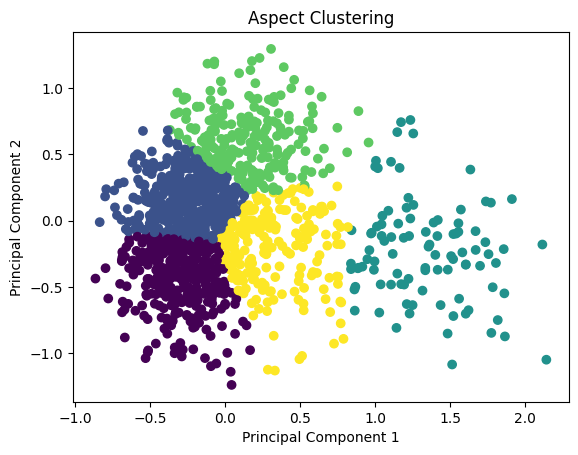

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(aspect_vectors)

# Cluster using the optimal k from the elbow method
optimal_k = 5  # replace with your chosen value
kmeans = KMeans(n_clusters=optimal_k)
clusters = kmeans.fit_predict(reduced_vectors)

# Plot
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=clusters, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Aspect Clustering')
plt.show()


In [ ]:
# Convert the Aspect_Sentiments column to a list of dictionaries for exploding
processed_data['Aspect_Sentiments'] = processed_data['Aspect_Sentiments'].apply(lambda x: [x])

In [ ]:
# Explode the dataframe based on the Aspect_Sentiments column
exploded_df = processed_data.explode('Aspect_Sentiments')

In [ ]:
# Split the dictionaries into two separate columns: Aspect and Sentiment
sentiment_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}
exploded_df['Aspect'] = exploded_df['Aspect_Sentiments'].apply(lambda x: list(x.keys())[0] if x else None)
exploded_df['Sentiment'] = exploded_df['Aspect_Sentiments'].apply(lambda x: sentiment_mapping[list(x.values())[0]] if x else None)

In [ ]:
# Drop the Aspect_Sentiments column and other unnecessary columns
structured_data = exploded_df[['Comments_preprocessed', 'Aspect', 'Sentiment']]

# Drop rows with NaN values
structured_data = structured_data.dropna()

# Display the structured dataframe
print(structured_data.head())

                               Comments_preprocessed            Aspect  \
0  direct communication .excellent product service .     communication   
1                             fast effective service           service   
2                        immediately service problem    serviceproblem   
3               effective application court employer  applicationcourt   
4            immediately effective treatment problem  treatmentproblem   

   Sentiment  
0          1  
1          2  
2          1  
3          1  
4          2  


In [ ]:
!pip install transformers
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 1.8 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(structured_data, test_size=0.2, random_state=42)

In [ ]:
from torch.utils.data import Dataset, DataLoader

class ABSADataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
from transformers import BertTokenizer

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenizing train data
train_sentences = train_data['Comments_preprocessed'].tolist()
train_aspects = train_data['Aspect'].tolist()
train_labels = train_data['Sentiment'].tolist()
train_inputs = tokenizer(text=train_sentences, text_pair=train_aspects, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
train_dataset = ABSADataset(train_inputs, train_labels)

# Tokenizing val data
val_sentences = val_data['Comments_preprocessed'].tolist()
val_aspects = val_data['Aspect'].tolist()
val_labels = val_data['Sentiment'].tolist()
val_inputs = tokenizer(text=val_sentences, text_pair=val_aspects, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
val_dataset = ABSADataset(val_inputs, val_labels)


In [ ]:
# # Run this block if we want to stop our training based on accuracy
# !pip install datasets
# from datasets import load_metric
# from transformers import EvalPrediction

# metric = load_metric("accuracy")

# def compute_metrics(p: EvalPrediction):
#     return metric.compute(predictions=torch.argmax(p.predictions, axis=1), references=p.label_ids)

In [ ]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
import torch

# Initialize BERT for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)


training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=8,
    num_train_epochs=1,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,  # Load the best model at the end of training
    metric_for_best_model="loss",  # Use val_loss as the metric to determine the "best" model
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Train the model
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.371900,0.259809


TrainOutput(global_step=1150, training_loss=0.3362643357981806, metrics={'train_runtime': 257.4539, 'train_samples_per_second': 35.735, 'train_steps_per_second': 4.467, 'total_flos': 605160860774400.0, 'train_loss': 0.3362643357981806, 'epoch': 1.0})

In [ ]:
predictions = trainer.predict(val_dataset)
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(axis=1)


In [ ]:
from sklearn.metrics import balanced_accuracy_score

bal_acc = balanced_accuracy_score(y_true, y_pred)
print(f"Balanced Accuracy: {bal_acc:.4f}")



Balanced Accuracy: 0.8340


In [ ]:
model.save_pretrained("./my_absa_model")

In [ ]:
!zip -r my_absa_model.zip my_absa_model/

  adding: my_absa_model/ (stored 0%)
  adding: my_absa_model/config.json (deflated 51%)
  adding: my_absa_model/pytorch_model.bin (deflated 7%)


In [ ]:
# Download the model
from google.colab import files
files.download('my_absa_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer
import torch

# 1. Load the trained model and tokenizer
model_path = "/content/my_absa_model"  # adjust path if necessary
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()


new_data = [
    {"sentence": "The food was amazing", "aspects": ["food"]},
    {"sentence": "The service was terrible", "aspects": ["service"]},
    {"sentence": "The Company's service is very good, and the personel is kind", "aspects" : ["service","personel"]}
]


results = []

for entry in new_data:
    sentence = entry["sentence"]
    aspects = entry["aspects"]

    for aspect in aspects:
        encoded_input = tokenizer.encode_plus(sentence, aspect, return_tensors='pt', padding='max_length', max_length=128, truncation=True)
        encoded_input = {key: tensor.to(device) for key, tensor in encoded_input.items()}

        with torch.no_grad():
            output = model(**encoded_input)
            prediction = torch.argmax(output.logits, dim=1).item()

        results.append({
            "sentence": sentence,
            "aspect": aspect,
            "predicted_sentiment": prediction
        })

print(results)



[{'sentence': 'The food was amazing', 'aspect': 'food', 'predicted_sentiment': 2}, {'sentence': 'The service was terrible', 'aspect': 'service', 'predicted_sentiment': 0}, {'sentence': "The Company's service is very good, and the personel is kind", 'aspect': 'service', 'predicted_sentiment': 1}, {'sentence': "The Company's service is very good, and the personel is kind", 'aspect': 'personel', 'predicted_sentiment': 1}]


In [ ]:
sentiment_counts = train_data['Sentiment'].value_counts()
print(sentiment_counts)

1    6398
2    2526
0     276
Name: Sentiment, dtype: int64


In [ ]:
!unzip /content/my_absa_model.zip


Archive:  /content/my_absa_model.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/my_absa_model.zip or
        /content/my_absa_model.zip.zip, and cannot find /content/my_absa_model.zip.ZIP, period.


In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer,  Trainer, TrainingArguments

import zipfile

# Unzip the saved model directory
with zipfile.ZipFile("/content/my_absa_model.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

# Load the model and tokenizer from the unzipped directory
model_path = "/content/my_absa_model"
model = BertForSequenceClassification.from_pretrained(model_path)
#tokenizer = BertTokenizer.from_pretrained(model_path)



BadZipFile: ignored